In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

import copy
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

In [2]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.5.1+cu124
cuda


In [3]:
dataset = pd.read_csv("../emnist/emnist-letters-train.csv")

In [4]:
images = np.array(dataset, dtype='float')
images.shape

(88799, 785)

In [5]:
letter_categories = images[:, 0]
images = images[:, 1:]

In [6]:
np.unique(letter_categories)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.])

In [7]:
images = images.reshape((-1, 1, 28, 28))

In [8]:
labels = copy.deepcopy(letter_categories) - 1
letter_categories = ['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
images = torch.tensor(images, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.long)
images /= torch.max(images)

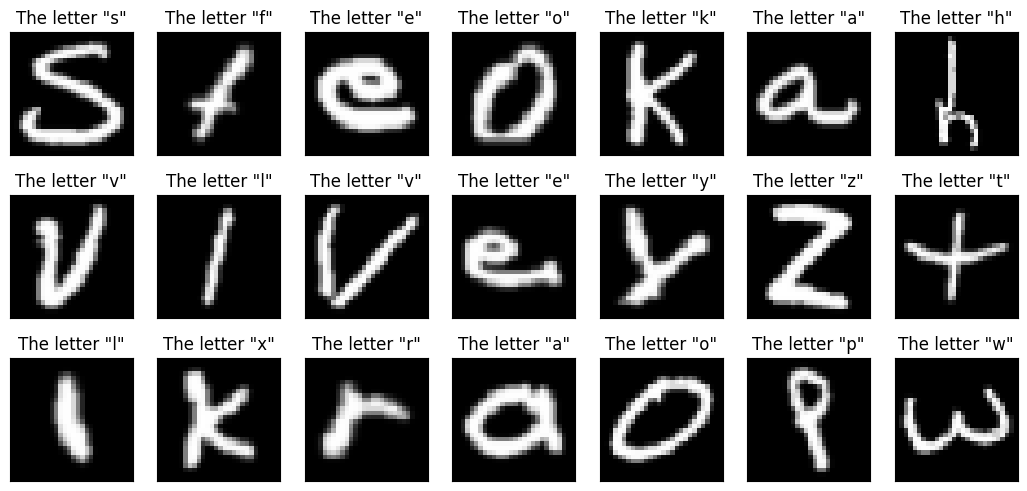

In [10]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letter_categories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [11]:
train_x, test_x, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)
train_dataset = TensorDataset(train_x, train_labels)
test_dataset = TensorDataset(test_x, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
class myEMNIST(nn.Module):
  def __init__(self, out_channels: int, out_channels2: int):
    super().__init__()

    self.conv1 = nn.Conv2d(1, out_channels, 3, 1, padding=1) # 28 - 3 + 2 * 1 / 1 + 1 = 28 -> 14 bo maxpool
    self.conv2 = nn.Conv2d(out_channels,out_channels2, 3, 1, padding=1) # 14 / 2 = 7
    self.linear1 = nn.Linear(out_channels2 * 7 * 7, 128)
    self.linear2 = nn.Linear(128, 26)
    self.bc1 = nn.BatchNorm2d(out_channels)
    self.bc2 = nn.BatchNorm2d(out_channels2)

    self.dropout = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2, 2)
    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout2(x)
    x = self.linear2(x)
    return x


In [13]:
def train_the_model(out_channels: int, out_channels2: int):
  loss_fn = nn.CrossEntropyLoss()
  model = myEMNIST(out_channels=out_channels, out_channels2=out_channels2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  train_err = []
  test_err = []
  train_loss = []
  test_loss = []

  model.train()

  for epoch in range(1):
    batch_loss = []
    batch_err = []
    for batch, (X, y) in enumerate(train_loader):
      X, y = X.to(device), y.to(device)
      yHat = model(X)
      loss = loss_fn(yHat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_loss.append(loss.item())
      batch_err.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    train_loss.append(np.mean(batch_loss))
    train_err.append(np.mean(batch_err))

    ### test performance
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = model(X)
      loss = loss_fn(yHat,y)

    # get loss and error rate from the test batch
    test_loss.append(loss.item())
    test_err.append(100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item())

  return train_loss,test_loss,train_err,test_err,model

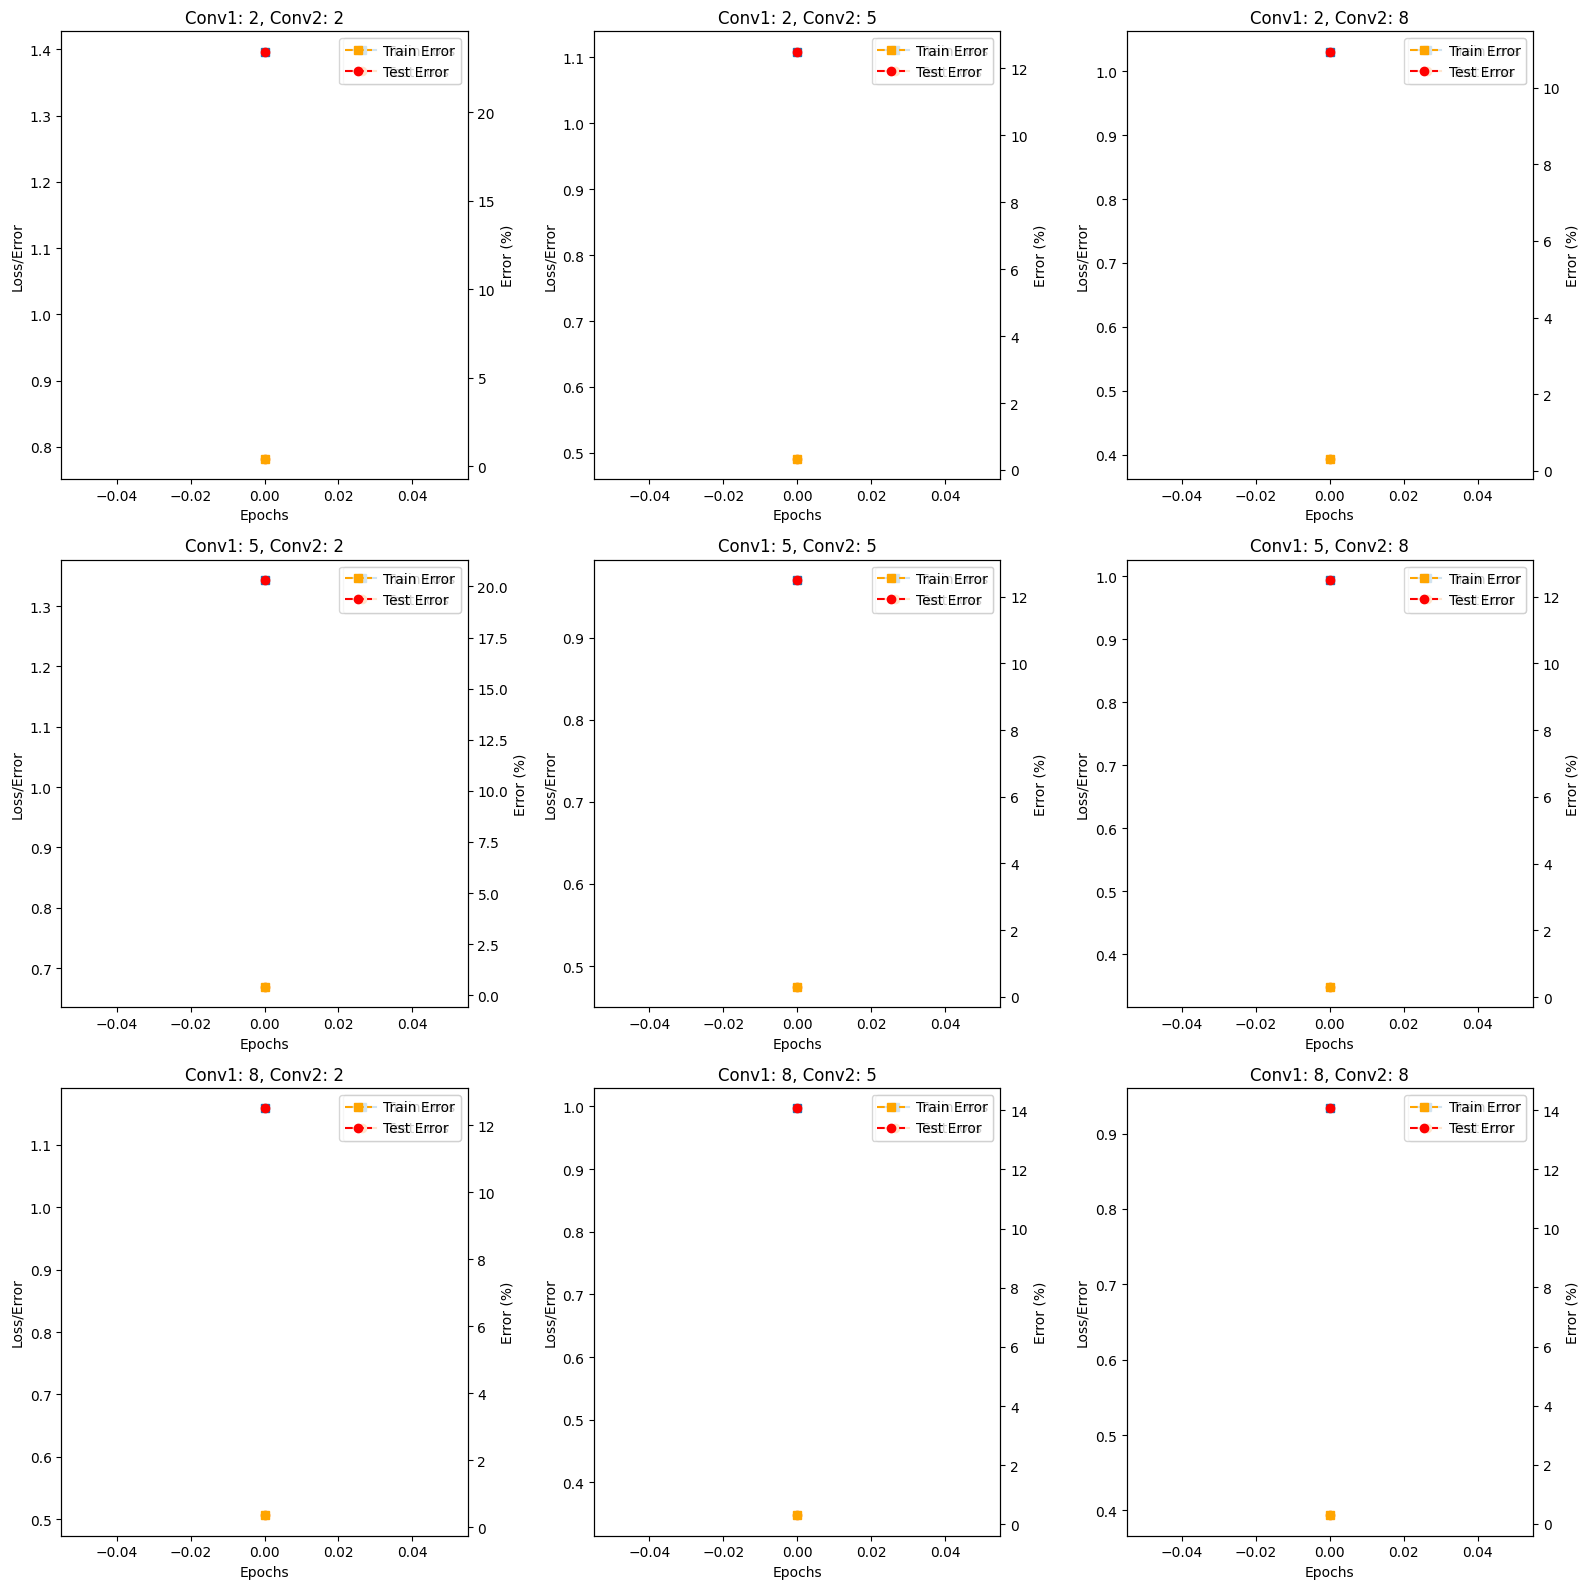

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# numbers definiuje kombinacje liczby kanałów
numbers = [2, 5, 8]

for i, out_channels in enumerate(numbers):
    for j, out_channels2 in enumerate(numbers):
        ax = axes[i, j]

        # Pobierz wyniki dla danej kombinacji
        train_loss, test_loss, train_err, test_err, model = train_the_model(out_channels=out_channels, out_channels2=out_channels2)

        # Wykres strat
        ax.plot(train_loss, 's-', label='Train Loss')
        ax.plot(test_loss, 'o-', label='Test Loss')
        ax.set_title(f'Conv1: {out_channels}, Conv2: {out_channels2}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss/Error')
        ax.legend()

        # Opcjonalnie dodaj wykres błędów
        ax2 = ax.twinx()  # Druga oś Y
        ax2.plot(train_err, 's--', color='orange', label='Train Error')
        ax2.plot(test_err, 'o--', color='red', label='Test Error')
        ax2.set_ylabel('Error (%)')
        ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


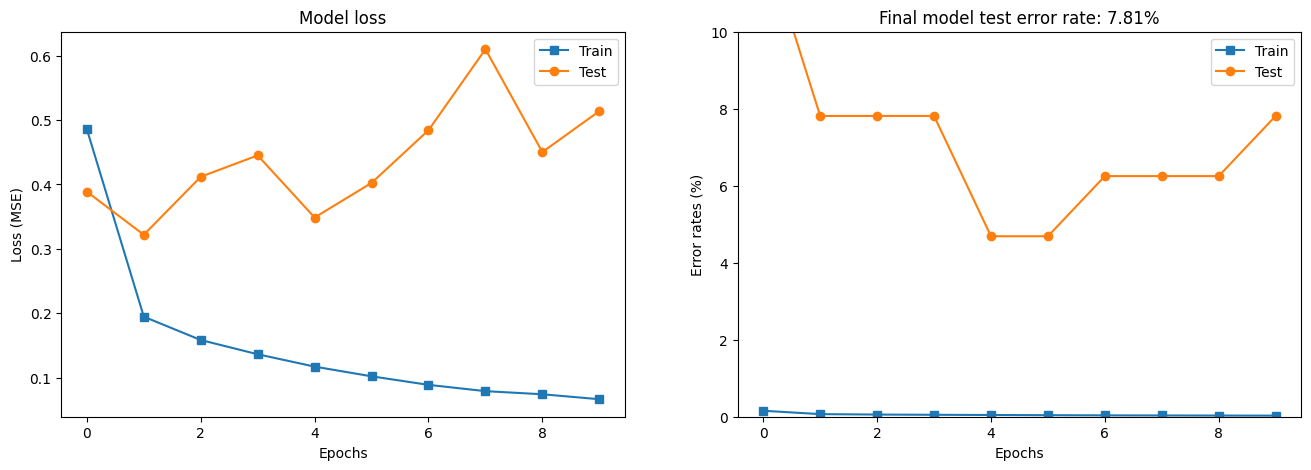

In [162]:
# fig,ax = plt.subplots(3,3,figsize=(16,10))
#
#
#
# ax[0].plot(train_loss,'s-',label='Train')
# ax[0].plot(test_loss,'o-',label='Test')
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Loss (MSE)')
# ax[0].set_title('Model loss')
# ax[0].legend()
#
# ax[1].plot(train_err,'s-',label='Train')
# ax[1].plot(test_err,'o-',label='Test')
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Error rates (%)')
# ax[1].set_title(f'Final model test error rate: {test_err[-1]:.2f}%')
# ax[1].set_ylim([0, 10])
# ax[1].legend()
#
# plt.show()

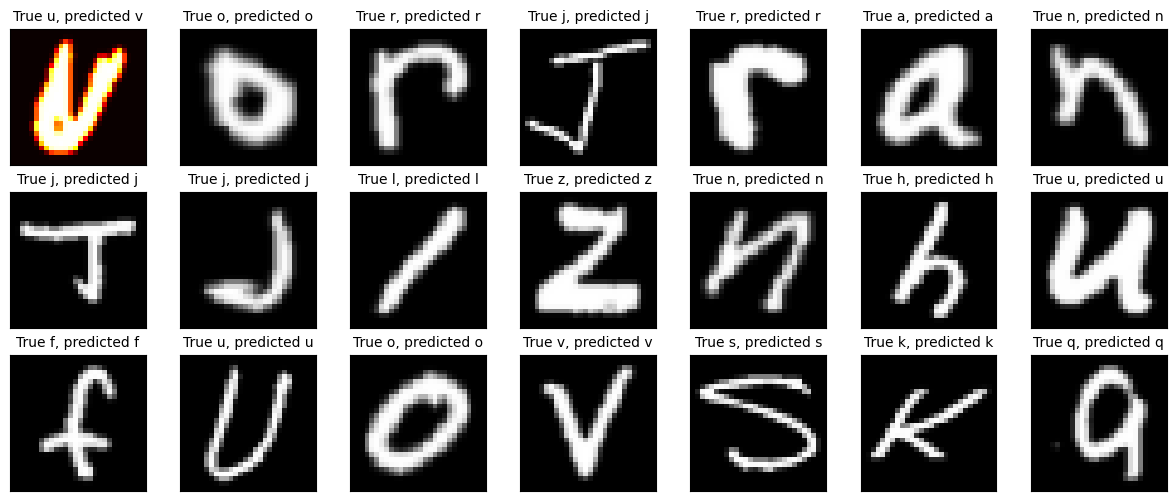

In [163]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(train_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = model(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letter_categories[ y[randex[i]] ]
  predLetter = letter_categories[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'

  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Accuracy by letter

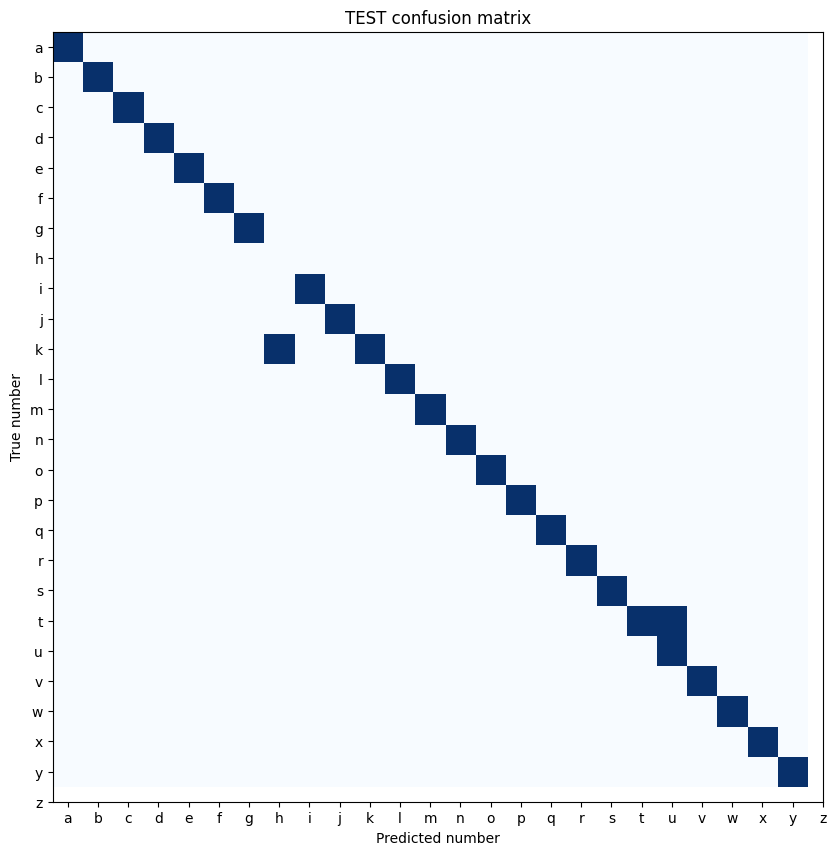

In [164]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letter_categories)
plt.yticks(range(26),labels=letter_categories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()